# Transfer Learning Job Profiles

The following graphs and statistics capture the profile of the transfer learning experiments.

In [299]:
# NOTEBOOK VARIABLES

experiment = "sharded_1"
clusters_file = "clusters.csv"

In [314]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

dir_prefix = "experiment_data/job_profiles"

cluster_models_stats_df = pd.read_csv(f"{dir_prefix}/cluster_model_stats_{experiment}.csv", header=0).sort_values(by="cluster_id")
centroid_models_stats_df = pd.read_csv(f"{dir_prefix}/centroid_stats_{experiment}.csv", header=0).sort_values(by="cluster_id")
tasks_df = pd.read_csv(f"{dir_prefix}/experiment_profile_{experiment}.csv", header=1)
centroid_models_stats_df

,gis_join,cluster_id,number_records,time_ms,rmse,iterations,best_reg_param,best_tolerance,best_epsilon
26,G1800570,0,2160,821370,6.614908,2,0.0,0.001,1.35
11,G1300950,1,2520,821158,7.511312,2,0.0,0.001,1.35
47,G4900010,2,17280,824595,4.761166,2,0.0,0.001,1.35
18,G4800790,3,5760,821326,5.971569,3,0.0,0.001,1.35
38,G3600710,4,5400,823396,6.476093,2,0.0,0.001,1.35
23,G3701310,5,3240,820962,7.716109,2,0.0,0.001,1.35
2,G1200090,6,6120,818796,7.634914,2,0.0,0.001,1.35
16,G2001090,7,6480,821192,6.487613,3,0.0,0.001,1.35
45,G4100650,8,16920,824327,3.707888,3,0.0,0.001,1.35
3,G3700210,9,4320,819033,7.059683,2,0.1,0.001,1.35


In [301]:
def human_time(difference_ms):
    return datetime.timedelta(milliseconds=difference_ms)

class Cluster:
    
    def __init__(self, cluster_id):
        self.id = cluster_id
        self.gis_joins = []
        self.center_gis_join = ""
        

class Task:
    
    def __init__(self, task_id, name, begin, end, time_seconds, gis_join="", cluster_id=-1):
        self.id = task_id
        self.name = name
        self.begin = begin
        self.end = end
        self.time_seconds = time_seconds
        self.gis_join = gis_join
        self.cluster_id = cluster_id
        
    def __repr__(self):
        return repr(f"Task: id={self.id}, name={self.name}, begin={self.begin}, end={self.end}, time_seconds={self.time_seconds}")
    
    
class CentroidModelTasks:
    
    def __init__(self):
        self.run_tasks = []
        
        
class ClusterLRModelTasks:
    
    def __init__(self):
        self.run_tasks = {}
        self.persist_tasks = {}
        self.train_all_tasks = {}
        self.train_tasks = {}
        
        

In [302]:
experiment_task = None
centroid_model_tasks = CentroidModelTasks()
cluster_lr_model_tasks = ClusterLRModelTasks()
clusters = {}

In [303]:
for i, row in clusters_df.iterrows():
    cluster_id = row["cluster_id"]
    if cluster_id not in clusters:
        clusters[cluster_id] = Cluster(cluster_id)
    
    if row["is_center"]:
        clusters[cluster_id].center_gis_join = row["gis_join"]
    else:
        clusters[cluster_id].gis_joins.append(row["gis_join"])
        

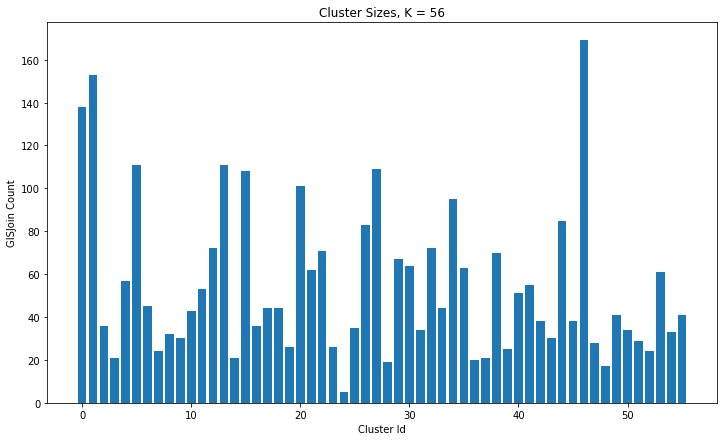

In [311]:
# ---- Plot Clusters Bar Chart -----

cluster_sizes = []
for i in range(0,56):
    cluster_sizes.append(len(clusters[i].gis_joins)+1)

plt.figure(figsize=(12,7))
plt.bar(range(0, len(clusters)), cluster_sizes)
plt.title("Cluster Sizes, K = 56")
plt.xlabel("Cluster Id")
plt.ylabel("GISJoin Count")
plt.show()

In [305]:
# ---- Process Tasks DF ----
for i, row in tasks_df.iterrows():
    if (i == 0):
        experiment_task = Task(i, row["name"], row["begin"], row["end"], row["time_seconds"])
    else:
        parts = row["name"].split(";")
        task_type = parts[0]
        task_name = parts[1]
        task_gis_join = parts[2][len("gisJoin=")+1:]
        task_cluster_id = str(parts[3][len("clusterId="):])
        
        new_task = Task(i, task_name, row["begin"], row["end"], row["time_seconds"], 
                        gis_join=task_gis_join, cluster_id=task_cluster_id)
        
        if (task_type == "CentroidModel"):
            
            if ("run()" in task_name):
                centroid_model_tasks.run_tasks.append(new_task)
        
                
        elif (task_type == "ClusterLRModels"):
            
            if ("run()" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.run_tasks:
                    cluster_lr_model_tasks.run_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.run_tasks[task_cluster_id].append(new_task)
                    
            elif ("Cluster" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.persist_tasks:
                    cluster_lr_model_tasks.persist_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.persist_tasks[task_cluster_id].append(new_task)
                    
            elif ("Train all" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.train_all_tasks:
                    cluster_lr_model_tasks.train_all_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.train_all_tasks[task_cluster_id].append(new_task)
                    
            elif ("train()" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.train_tasks:
                    cluster_lr_model_tasks.train_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.train_tasks[task_cluster_id].append(new_task)
                    
                    

Experiment sharded_1 Time: 1971.22 seconds
Total time taken to train/evaluate 56 centroid models: 0:14:10.356000


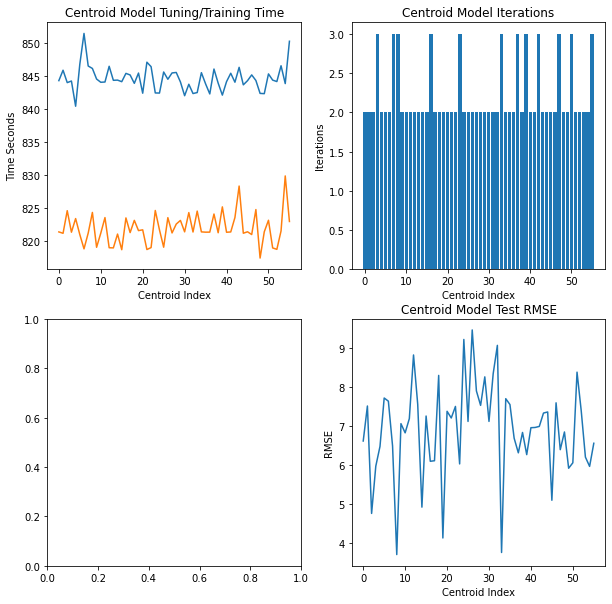

In [325]:
# ---- Centroid Models Plotting -----

centroid_run_tasks = []
for i in range(0,56):
    run_task = centroid_model_tasks.run_tasks[i]
    centroid_run_tasks.append(run_task.time_seconds)


total_centroid_time = human_time(centroid_model_tasks.run_tasks[-1].end 
                                 - centroid_model_tasks.run_tasks[0].begin)

total_experiment_time = experiment_task.time_seconds

print("Experiment %s Time: %s seconds" % (experiment, total_experiment_time))
print("Total time taken to train/evaluate 56 centroid models:", total_centroid_time)



# Create a figure
figure, axis = plt.subplots(2, 2, figsize=(10,10))


# For Total End-to-End Time
axis[0, 0].plot(centroid_run_tasks)
axis[0, 0].set_title("Centroid Model E2E Time")
axis[0, 0].set_ylabel("Seconds")
axis[0, 0].set_xlabel("Centroid Index")

# For Iterations
axis[0, 1].bar(range(0, 56),centroid_models_stats_df["iterations"].to_list())
axis[0, 1].set_title("Centroid Model Iterations")
axis[0, 1].set_ylabel("Iterations")
axis[0, 1].set_xlabel("Centroid Index")

# For Training Time
axis[0, 0].plot((centroid_models_stats_df["time_ms"]/1000.0).to_list())
axis[0, 0].set_title("Centroid Model Tuning/Training Time")
axis[0, 0].set_ylabel("Time Seconds")
axis[0, 0].set_xlabel("Centroid Index")

# For RMSE
axis[1, 1].plot(centroid_models_stats_df["rmse"].to_list())
axis[1, 1].set_title("Centroid Model Test RMSE")
axis[1, 1].set_ylabel("RMSE")
axis[1, 1].set_xlabel("Centroid Index")

# show plot
plt.show()

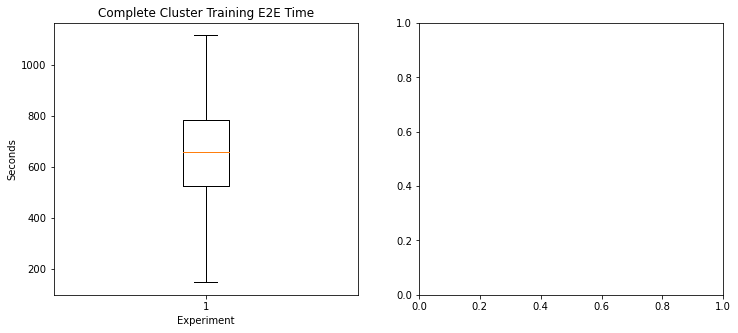

In [289]:
# ---- Cluster Transfer Learning Model Plotting -----

clusters_run_time_seconds = [val[0].time_seconds for val in cluster_lr_model_tasks.run_tasks.values()]
    
# Create a figure
figure, axis = plt.subplots(1, 2, figsize=(12,5))

# For Cluster Training End-to-End Time
axis[0].boxplot(clusters_run_time_seconds)
axis[0].set_title("Complete Cluster Training E2E Time")
axis[0].set_ylabel("Seconds")
axis[0].set_xlabel("Experiment")

plt.show()

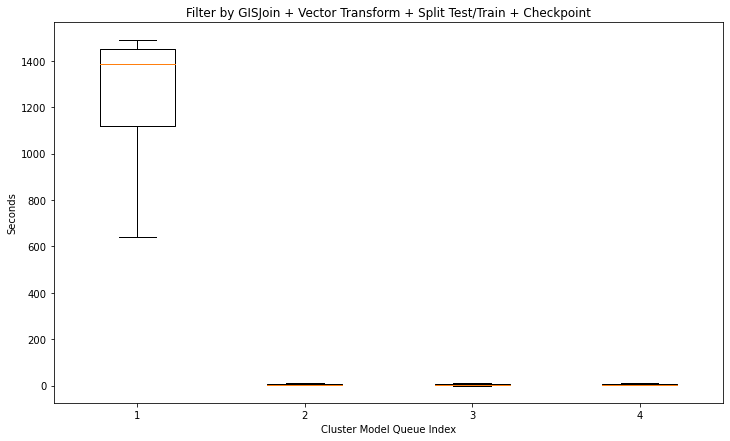

In [249]:
num_steps = 4
model_seconds = []
for i in range(0, num_steps):
    model_seconds.append([])
    for cluster_id, tasks in cluster_lr_model_tasks.checkpoint_tasks.items():
        model_seconds[i].append(tasks[i].time_seconds)

plt.figure(figsize=(12,7))
plt.boxplot(model_seconds)
plt.title("Filter by GISJoin + Vector Transform + Split Test/Train + Checkpoint")
plt.ylabel("Seconds")
plt.xlabel("Cluster Model Queue Index")
plt.show()

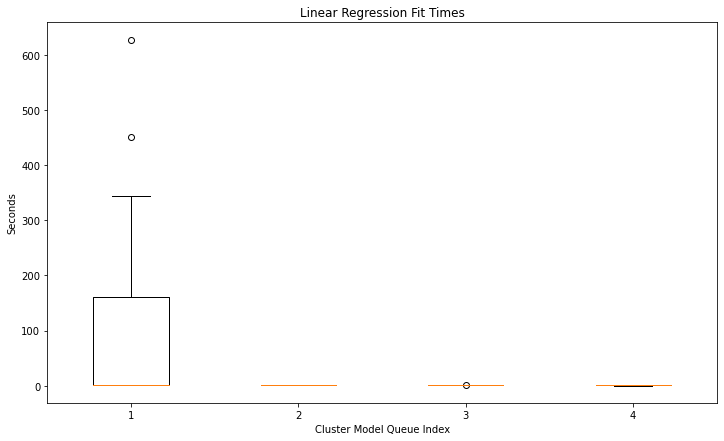

In [248]:
num_steps = 4
model_seconds = []
for i in range(0, num_steps):
    model_seconds.append([])
    for cluster_id, tasks in cluster_lr_model_tasks.fit_tasks.items():
        model_seconds[i].append(tasks[i].time_seconds)

plt.figure(figsize=(12,7))
plt.boxplot(model_seconds)
plt.title("Linear Regression Fit Times")
plt.ylabel("Seconds")
plt.xlabel("Cluster Model Queue Index")
plt.show()

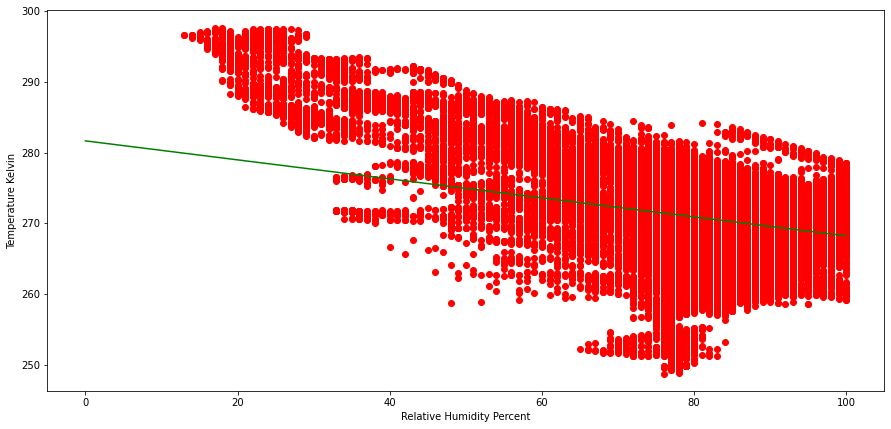

In [276]:
import numpy as np
gis_join_df = pd.read_csv("experiment_data/rows.csv", header=0)
iterations_df = pd.read_csv("experiment_data/iterations.csv", header=0)

X1 = gis_join_df["relative_humidity_percent"].to_list()
Y1 = gis_join_df["label"].to_list()

X2 = np.linspace(0, 100, 100)
Y2 = -0.13438541379122257 * X2 + 281.6580


plt.figure(figsize=(15,7))
plt.plot(X1,Y1, "ro")
plt.plot(X2,Y2, "g-")
plt.xlabel("Relative Humidity Percent")
plt.ylabel("Temperature Kelvin")
plt.show()



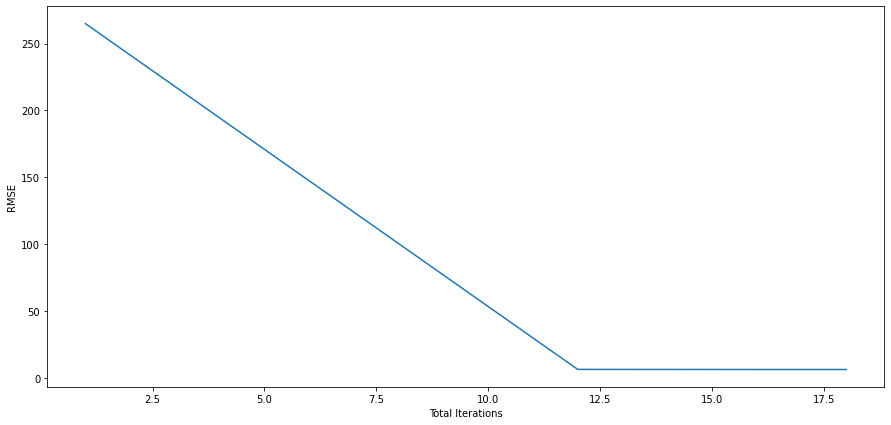

In [277]:
X1 = iterations_df["total_iterations"].to_list()
Y1 = iterations_df["rmse"].to_list()

plt.figure(figsize=(15,7))
plt.plot(X1,Y1)
plt.xlabel("Total Iterations")
plt.ylabel("RMSE")
plt.show()